In [172]:
#!/afs/inf.ed.ac.uk/user/s14/s1413557/miniconda2/bin/python

import os
import sys
import numpy as np
import pandas as pd
import cv2
import copy
import pymatlab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import moviepy as mp
from scipy import signal, stats
from matplotlib.path import Path
from bitarray import bitarray
from moviepy.editor import *
from sklearn.decomposition import PCA
from __future__ import print_function #ffs

from datetime import datetime

# Functions
---

In [2]:
def cleanLine(a):
    # Input:  corrupt 01 string
    # Return: cleaned  01 string
    length = len(a)//8
    binary = ""
    i = 0
    while i < length:
        byto16 = a[i*8:(i*8)+16]
        if byto16 == "0101110000110000":   # \0 -> null
            binary += "00000000"
            i+= 2
        elif byto16 == "0101110001011010": # \Z -> \x1a ???
            binary += "00011010"
            i+= 2
        elif byto16 == "0101110001101110": # \n -> \x0a
            binary += "00001010"
            i+= 2
        elif byto16 == "0101110001110010": # \r -> \x20
            binary +=  "00100000"
            i+= 2
        elif byto16 == "0101110000100010": # \" -> "
            binary += "00100010"
            i+= 2
        elif byto16 == "0101110000100111": # \' -> '
            binary += "00100111"
            i+= 2
        elif byto16 == "0101110001011100": # \\ -> \
            binary += "01011100"
            i+= 2
        else:
            binary += a[i*8:(i+1)*8]
            i+= 1
    return binary

In [3]:
def extractMeta(string, print_values=False):
    # Took a binary string of bb_cc, extract metadata from it.
    # 11:11:10:10:11:3:string
    # X :Y :W :H :x1:P:contour
    
    if len(string) < 56:
        raise Exception('Sutrin Not Rong Enafu')
    contX = int(string[0:11],2)
    contY = int(string[11:22],2)
    contH = int(string[22:32],2)
    contW = int(string[32:42],2)
    firstXPoint = int(string[42:53],2)
    padding = int(string[53:56],2)
    string2 = string[56:]
    
    if print_values:
        print("contX       Binary Value: {0}  Interpreted Value: {1}".format(string[0:11],contX))
        print("contY       Binary Value: {0}  Interpreted Value: {1}".format(string[11:22],contY))
        print("contH       Binary Value: {0}   Interpreted Value: {1}".format(string[22:32],contH))
        print("contW       Binary Value: {0}   Interpreted Value: {1}".format(string[32:42],contW))
        print("firstXPoint Binary Value: {0}  Interpreted Value: {1}".format(string[42:53],firstXPoint))
        print("padding     Binary Value: {0}          Interpreted Value: {1}".format(string[53:56],padding))
        print("Chaincode   Binary Value: \n{0}".format(string2))
    
    return (contX, contY, contW, contH, firstXPoint, padding, string2)

In [4]:
def movePoint(point, num):
    pointnew = point[:]
    if num == 0:
        pointnew[0] += 1
    if num == 1:
        pointnew[0] += 1
        pointnew[1] += 1
    if num == 2:
        pointnew[1] += 1
    if num == 3:
        pointnew[0] += -1
        pointnew[1] += 1
    if num == 4:
        pointnew[0] += -1
    if num == 5:
        pointnew[0] += -1
        pointnew[1] += -1
    if num == 6:
        pointnew[1] += -1
    if num == 7:
        pointnew[0] += 1
        pointnew[1] += -1
    return pointnew

In [5]:
def getContour(string, return_what="Normalized", debug=False):
    
    contX, contY, contW, contH, firstXPoint, padding, binary2 = extractMeta(string,print_values=debug)
    
    point = [firstXPoint,contY]
    points = []
    points.append(point)
    
    lmx = firstXPoint #left most X, to fix bug and stuff
    
    for i in range((len(binary2)-padding)/3):
        num = int(binary2[i*3:(i+1)*3],2)    
        pointnew = movePoint(point, num)
        points.append(pointnew)
        point = pointnew
        if point[0]<lmx:
            lmx = point[0]
            
    if point != points[0]:
        points.append(points[0])
        
    points2 = [(elem1-int(lmx)+10, elem2-int(contY)+10) for elem1, elem2 in points]
    points3 = [(elem1-lmx+contX, elem2) for elem1, elem2 in points]
    
    if return_what == "Both":
        return (points2, points3)
    if return_what == "Original":
        return points3
    return points2

In [6]:
def FEIF(string, case="320x240", return_info=False):
    
    if case == "320x240":
    #case 320x240
    # top 0 right 314 bottom 239 left 5 tsbottom 15 tsright 162
    # +1 for soft boundary
        top = 0
        right = 313
        bottom = 238
        left = 6
        tsright = 163
        tsbottom = 16 
    else:
    #case 640x480
    # top 0 right 633 bottom 479 left 5 tsbottom 32 tsright 265
        top = 0
        right = 632
        bottom = 478
        left = 6
        tsright = 266
        tsbottom = 33
    
    points2, points3 = getContour(string, return_what="Both")
    length = len(points2)
    
    delta = 0
    reject = False
    
   #===========================================================  
    for x, y in points2:
        if x == 100 or y == 100:
            delta += 1
    if delta >= 10:
        reject = True
   #===========================================================  
    if not reject:
        for x, y in points3:
            if x <= left or x >= right or y<=top or y >= bottom or (x <= tsright and y <= tsbottom):
                delta += 1
    if delta >= 25:
        reject = True
   #===========================================================  
    if return_info:
        return (reject,delta,length)
    else:
        return reject

In [7]:
def getMask(normilizedContourPoints):
    #VERY SLOW DONT USE
    p = Path(normilizedContourPoints)
    nx, ny = 100, 100
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T
    grid = p.contains_points(points)
    grid = grid.reshape((ny,nx))
    return grid

In [8]:
def normalizeRGB(image):
    weight = np.sum(image,axis=2,dtype = np.uint16)
    weight[weight < 1] = 1
    return image/(weight*1.0)[:,:,None]

In [9]:
def seperate_fish(contour,w):
    mask = np.full((100,100), 0, dtype=np.uint8)
    cv2.fillPoly(mask, np.array([contour], dtype=np.int32), (255,))
    moments = cv2.moments(mask)
    (x, y) = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))
    
    hl = int(round(9+w*0.25))
    hr = int(round(9+w*0.75))
    
    full_fish = getMask(contour)
    head_fish = copy.deepcopy(full_fish)
    head_fish[:,:x]=False
    tail_fish = copy.deepcopy(full_fish)
    tail_fish[:,x:]=False
    top_fish = copy.deepcopy(full_fish)
    top_fish[y:,:]=False
    bot_fish = copy.deepcopy(full_fish)
    bot_fish[:y,:]=False
    hhead_fish = copy.deepcopy(full_fish)
    hhead_fish[:,:hr]=False
    htail_fish = copy.deepcopy(full_fish)
    htail_fish[:,hl:]=False
    
    return (full_fish,head_fish,tail_fish,top_fish,bot_fish,hhead_fish,htail_fish)

In [10]:
def loadMovids():
    path = '/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/movie_ids_info.txt'
    if os.name == "nt":
        path = 'E:/movie_ids_info.txt'
    with open(path) as f:
        movs = f.readlines()
    return np.array([x.strip().split(",") for x in movs])

In [11]:
def loadSql(path, frame_info, returnDict=False):
    
    sqlDict = dict()
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            try:
                detid, fid, vid, what, date, rest = line.split(",",5)
                binary, what1, what2, what3 = rest.rsplit(",",3)
                string = binary[1:-1]
                a = bitarray()
                a.frombytes(string)
                sqlDict[int(detid)] = (a,fid)
            except ValueError:
                ValueError.message
                continue
                
    length = len(frame_info[:,0])
    mask = [False] * length
    sql = [-1] * length
    fid = [-1] * length
    for index, detid in enumerate(frame_info[:,0]):
        try:
            #sql[index] = sqlDict[int(detid)][0]
            sql[index] = cleanLine(sqlDict[int(detid)][0].to01())
            fid[index] = sqlDict[int(detid)][1]
            mask[index] = True
        except KeyError:
            continue
            
    if returnDict:
        return mask, sql, fid, sqlDict
    else:
        return mask, sql, fid

In [12]:
def loadSqlOriginal(path):
    #VERY OLD DONT USE
    ids = []
    original = []
    binaries = []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            try:
                detid, fid, vid, what, date, rest = line.split(",",5)
                binary, what1, what2, what3 = rest.rsplit(",",3)
                string = binary[1:-1]
                a = bitarray()
                a.frombytes(string)
                ids.append(detid)
                original.append(string)
                binaries.append(a)
            except ValueError:
                ValueError.message
                continue
    return np.vstack((ids,original,binaries)).T

In [13]:
def loadVideo(video_id, limit_output=True, limit_offset=0, limit_amount=20,
              print_info=True, print_image=True, print_time=False,
              classify=False):
    
    camera_id = video_id[1]
    if video_id[2] == "1":
        frame_size = "640x480"
    else:
        frame_size = "320x240"
    video_id = video_id[0]
    
    f2 = video_id[:2]
    f1 = f2[:1]
    #print(f1,f2)
    if print_time:
        time = datetime.now()

    path = '/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/summaries/{0}/{01}/'.format(f1,f2)
    path2 = '/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/sqldump/{0}/{01}/'.format(f1,f2)
    if os.name == "nt":
        path = 'E:/f4k_extracted_image/output/summaries/{0}/{01}/'.format(f1,f2)
        path2 = 'E:/f4ktable/{0}/{01}/'.format(f1,f2)
    
    headm = 'summary_'
    tailm = '.avi'
    headc = 'frame_info_'
    tailc = '.txt'
    movie = path + headm + video_id + tailm
    csv = path + headc + video_id + tailc
    sql = path2 + video_id + tailc

    if print_time:
        time = datetime.now()
    
    frame_info = np.genfromtxt(csv, delimiter=',',dtype=int)
    
    if len(frame_info) == 0:
        print("NO DETECTION IN VIDEO: {0}!".format(video_id))
        return ([], [], [], [], 0)
    
    clip = VideoFileClip(movie)
    fps = clip.fps
    duration = clip.duration
    frames = int(fps * duration)
    hasContour, contour, fish_id = loadSql(sql, frame_info)
    
    #Take out RGB arrays before stuff?
    #Replace clip reader with list, so dont have to delete stuff everytime.
    RGB = [None] * frames
    for i in range(frames):
        RGB[i] = clip.get_frame(i / clip.fps)
    if not(clip==[]):
        clip.reader.close()
    del clip
    
    if print_info:
        if print_time:
            print('Loading data took: {}'.format(datetime.now() - time))
        print('Using video_id: {0}'.format(video_id))
        print('Using movie, csv, sql paths: \n{0}\n{1}\n{2}'.format(movie,csv,sql))
        print('Video fps: {0}, duration {1}'.format(fps,duration))
        print('Video frame size: {0}, camera_id: {1}'.format(frame_size,camera_id))
        print('Total frames in video: ', frames)
        count1 = sum(hasContour)
        count2 = len(hasContour)
        print("{0} out of {1}, about {2} detection have a bounding box in sql."
              .format(count1,count2,"{0:.0f}%".format(count1/(count2*1.0) * 100)))
        
    if print_time:
        time = datetime.now()
        throw = 0
        keep = 0
        tot = 0
        for i in range(frames):
            if hasContour[i]:
                cline = contour[i]
                result = FEIF(cline,case=frame_size)
                if result:
                    throw += 1
                else:
                    keep += 1
                tot += 1
        if print_info and tot != 0:
            print('{0} out of {1} total detection is rejected by FEIF, {2} kept. Reject rate: {3}'
                  .format(throw,tot,keep,"{0:.0f}%".format(throw/(tot*1.0) * 100)))
            print('FEIF Runtime: {}'.format(datetime.now() - time))
    
    if print_image:
        
        if not(frames > limit_amount and limit_output): #limit output
            limit_amount = frames
        
        throw = 0
        keep = 0
        tot = 0
        
        f, ax = plt.subplots((limit_amount-limit_offset+4)/5,5,figsize=(15,3*((limit_amount-limit_offset+4)/5)))
        for i in range(limit_offset, limit_amount):
            plt.subplot((limit_amount-limit_offset+4)/5,5,i-limit_offset+1)
            plt.imshow(RGB[i])
            plt.xticks([])
            plt.yticks([])
            
            if classify:
                if hasContour[i]:
                    cline = contour[i]
                    plt.scatter(*zip(*getContour(cline, return_what="Normalized")),s=1)
                    result, delta, length = FEIF(cline,case=frame_size,return_info=True)
                    #for print X and Y range
                    contX, contY, contW, contH, firstXPoint, padding, binary2 = extractMeta(cline)
                    if result:
                        plt.gca().add_patch(patches.Rectangle((0,0),99,99,fill=False,linewidth=7,color='red'))
                        throw += 1
                    else:
                        plt.gca().add_patch(patches.Rectangle((0,0),99,99,fill=False,linewidth=7,color='green'))
                        keep += 1
                    tot += 1
                    plt.gca().set_xlabel("{0},{1},{2},{3:.0f}%\nX:{4}-{5} Y:{6}-{7}"
                                         .format(frame_info[i,0],length,delta,delta/(length*0.01),
                                                contX,contX+contW,contY,contY+contH))
                else:
                    plt.gca().add_patch(patches.Rectangle((0,0),99,99,fill=False,linewidth=7,color='yellow'))
                    plt.gca().set_xlabel("{0},NO CONTOUR".format(frame_info[i,0]))
            else:
                plt.gca().set_xlabel("{0},{1}".format(frame_info[i,0],frame_info[i,1:4]))
                plt.gca().add_patch(patches.Rectangle((9,9),frame_info[i,1],frame_info[i,2],
                                                      fill=False,linewidth=1,color='red'))
        
        if classify and not (tot == 0):
            print('{0} out of {1} images is rejected, {2} kept. Reject rate: {3:.0f}%'
                  .format(throw,tot,keep,throw/(tot*0.01)))
        plt.show()
    
    return (frame_info, RGB, hasContour, contour, fish_id, frames)


In [14]:
def plotContourOnImage(info, clip, hasContour, contour, picker, debug=False):
    det_id = int(info[picker,0])
    if hasContour[picker]:
        string2 = contour[picker]
        if debug:
            print("Printing detection_id: {0}".format(det_id))
        points2 = getContour(string2,debug=debug)

#         plt.subplots(1,1,figsize=(15,15))  
        plt.subplots(1,2,figsize=(15,10))  
        plt.subplot(121)
        plt.imshow(clip[picker]) 
        plt.xticks([])
        plt.yticks([])
        plt.subplot(122)
        plt.imshow(clip[picker])   
        plt.xticks([])
        plt.yticks([]) 
        plt.axvline(9,                linewidth=1, color='r', alpha=0.4)
        plt.axvline(10+info[picker,1],linewidth=1, color='r', alpha=0.4)
        plt.axhline(9,                linewidth=1, color='r', alpha=0.4)
        plt.axhline(10+info[picker,2],linewidth=1, color='r', alpha=0.4)
        plt.scatter(*zip(*points2),s=5)

        plt.show()

In [15]:
def plotContour(binary, add_milk=False):
    
    points2 = getContour(binary, return_what="Normalized")
    if add_milk:
        plt.imshow(getMask(points2))
    plt.scatter(*zip(*points2),s=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()

In [16]:
def plotContourFromOriginalFile(path, limit_amount=400, add_milk=False):
    if limit_amount > 0:
        plt.subplots((limit_amount+19)/20,20,figsize=(15,0.75*((limit_amount+19)/20)))
    with open(path,'r') as fp:
        for i, line in enumerate(fp):
            line = line[37:-3].split("),(")
            counter = 0
            
            for l in line:
                
                if  counter >= limit_amount:
                    continue
                counter += 1
                
                try:
                    detid, fid, vid, what, date, rest = l.split(",",5)
                    binary, what1, what2, what3 = rest.rsplit(",",3)
                    a = bitarray()
                    string = binary[1:-1]
                    a.frombytes(string)
                    binary = cleanLine(a.to01())
                except ValueError:
                    continue
                
                plt.subplot((limit_amount+19)/20,20,counter)
                plotContour(binary,add_milk=add_milk)
    plt.show()

In [17]:
def loadPickables(movs):
    pickables = []
    ids = []
    for i, item in enumerate(movs):
        if i == 1584:
            break
        date = item[0][-12:]
        if date[:8] == "20110422" or date[-4:] == "0800":
            pickables.append(item)
            ids.append(i)
    return (ids, pickables)

# Playground
---

In [18]:
movs = loadMovids()
ids, pickables = loadPickables(movs) #Movid having reference in F4K csv

Loading data took: 0:00:01.104000
Using video_id: 000091a58183e0358d5c3f8716c8491a#201101151720
Using movie, csv, sql paths: 
E:/f4k_extracted_image/output/summaries/0/00/summary_000091a58183e0358d5c3f8716c8491a#201101151720.avi
E:/f4k_extracted_image/output/summaries/0/00/frame_info_000091a58183e0358d5c3f8716c8491a#201101151720.txt
E:/f4ktable/0/00/000091a58183e0358d5c3f8716c8491a#201101151720.txt
Video fps: 25.0, duration 188.64
Video frame size: 320x240, camera_id: 37
Total frames in video:  4716
4716 out of 4716, about 100% detection have a bounding box in sql.
613 out of 4716 total detection is rejected by FEIF, 4103 kept. Reject rate: 13%
FEIF Runtime: 0:00:00.989000
5 out of 10 images is rejected, 5 kept. Reject rate: 50%


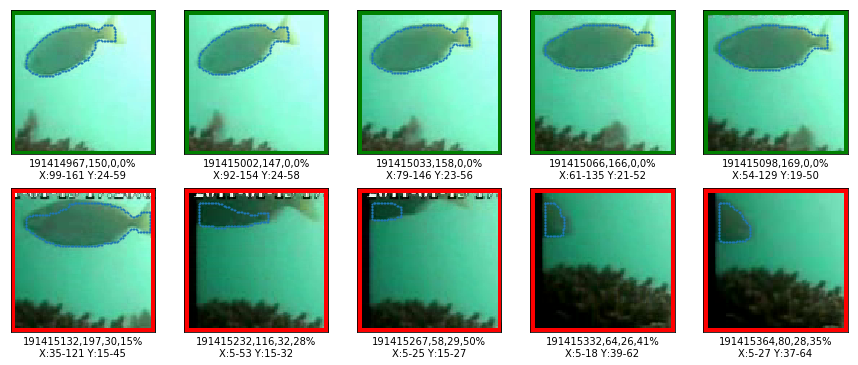

In [53]:
# 6 200-220: Broken contX, FEIF bugs
# 6 300-400: Ghost Fish?
# 7 severe no contour problem. 356/365 missing
# 31 No detection
# 41 Ghost Fish
# 56 No timestamp
# 77 Ghost Fish, broken contour
# 132 100% no contour
picker = 6
startframe = 100
endframe = 110
movid = movs[picker]
info, clip, hasContour, contour, fish_id, frames = loadVideo(movid,print_image=True,
                                                    print_time=True,
                                                    limit_offset=startframe,
                                                    limit_amount=endframe,
                                                    classify=True)

In [46]:
picker = 6
#picker2 = 177
movid = movs[picker]
info, clip, hasContour, contour, fish_id, frames = loadVideo(movid,print_info=True, print_image=False)
#plotContourOnImage(info, clip, hasContour, contour, picker2, debug=True)

Using video_id: 000091a58183e0358d5c3f8716c8491a#201101151720
Using movie, csv, sql paths: 
E:/f4k_extracted_image/output/summaries/0/00/summary_000091a58183e0358d5c3f8716c8491a#201101151720.avi
E:/f4k_extracted_image/output/summaries/0/00/frame_info_000091a58183e0358d5c3f8716c8491a#201101151720.txt
E:/f4ktable/0/00/000091a58183e0358d5c3f8716c8491a#201101151720.txt
Video fps: 25.0, duration 188.64
Video frame size: 320x240, camera_id: 37
Total frames in video:  4716
4716 out of 4716, about 100% detection have a bounding box in sql.


In [271]:
def get_tracks(info, clip, hasContour, contour, fish_id):
    
    time = datetime.now()
    counter = 0
    
    npfish = np.array(fish_id)
    det_id = info[:,0]
    length = len(hasContour)
    fishs = np.unique(npfish[hasContour])
    
    S = 10;
    W = 4
    G = signal.gaussian(2*W+1, std=1)
    G = G / np.sum(G)
    
    #Initialize gabor filters so we don't need to calculate it everytime.
    #Copy implement of Ahmad because sk-image and opencv's gabor work differently
    scales = np.repeat(np.arange(1.75,3,0.25),2)
    thetas = np.tile(np.array([0,90]),5)
    sigma_x = scales / np.pi * np.sqrt(np.log(2)/2) * 3 #(2^bandwidth+1)/(2^bandwidth-1); bdw=1;
    sigma_y = sigma_x/ 0.5 #gamma
    f = 1.0 / scales
    Sx = np.ceil(sigma_x).astype(int)
    Sy = np.ceil(sigma_y).astype(int)
    G_realz = [None]*10
    G_imagz = [None]*10
    for i in range(10):
        G_real = np.zeros((2*Sx[i]+1,2*Sy[i]+1))
        G_imag = np.zeros((2*Sx[i]+1,2*Sy[i]+1))
        for x in np.arange(-Sx[i],Sx[i]+1):
            for y in np.arange(-Sy[i],Sy[i]+1):
                xPrime = x * np.cos(thetas[i]) + y * np.sin(thetas[i])
                yPrime = y * np.cos(thetas[i]) - x * np.sin(thetas[i])
                ex = np.exp(-0.5*((xPrime/sigma_x[i])**2+(yPrime/sigma_y[i])**2))
                G_real[Sx[i]+x,Sy[i]+y] = ex * np.cos(2*np.pi*f[i]*xPrime)
                G_imag[Sx[i]+x,Sy[i]+y] = ex * np.sin(2*np.pi*f[i]*xPrime)
        wNorm = np.sqrt(np.sum(G_real**2+G_imag**2))
        G_realz[i] = G_real / wNorm
        G_imagz[i] = G_imag / wNorm
    
    #Set outputs
    animation_scores = np.zeros(length)
    #Reduce these stuff to single array
    contour_size = np.zeros(length)
    contour_skewness = np.zeros(length)
    contour_kurtosis = np.zeros(length)
    contour_sum = np.zeros(length)
    erraticity_size = np.zeros(length)
    erraticity_skewness = np.zeros(length)
    erraticity_kurtosis = np.zeros(length)
    erraticity_sum = np.zeros(length)
    norm_erraticity_size = np.zeros(length)
    norm_erraticity_skewness = np.zeros(length)
    norm_erraticity_kurtosis = np.zeros(length)
    norm_erraticity_sum = np.zeros(length)
    gabor_feature_mean = np.zeros((length,10))
    gabor_feature_std = np.zeros((length,10))
    
    for fish in fishs:
        mask = npfish == fish
        index = np.arange(length)[mask]
        track = det_id[mask]
        tracklen = len(index)
        #It's always sorted?
        #print("")
        #print("Checking stuff: {0}".format(track))
        
        #Animation Score
        if tracklen == 1:
            animation_score = 0
            #print("AS: {0}".format(animation_score))
        else:
            #Why don't we use linspace?
            if tracklen < 5:
                target = np.arange(tracklen-1)
            else:
                target = np.floor(np.arange(0.0, tracklen-2, tracklen * 0.25)).astype(int)
            if target[-1] != (tracklen - 2):
                target = np.append(target,tracklen - 2)
            
            scores = np.zeros(len(target))
            for i, t in enumerate(target):
                N = info[index[t],1]
                M = info[index[t],2]
                Z = 1 / (1.0 * M * N)
                sub_f_t = clip[index[t]][S:M+S, S:N+S, :].astype(int)
                sub_f_tp1 = clip[index[t+1]][S:M+S, S:N+S, :].astype(int)
                scores[i] =  np.linalg.norm(np.sum(sub_f_t-sub_f_tp1,2,dtype=int)) * Z
            
            animation_score = np.average(scores)
            #print("AS: {0}".format(animation_score))
        for i in index:
            animation_scores[i] = animation_score
            
        #Contour Stuff
        K = np.zeros(tracklen)
        for i in np.arange(tracklen):
            c = np.array(getContour(contour[index[i]]))
            X = c[:,0]
            Y = c[:,1]
            X1 = np.hstack((X[-W:],X,X[:W]))
            Y1 = np.hstack((Y[-W:],Y,Y[:W]))
            XX = np.convolve(X1,G,'same')
            YY = np.convolve(Y1,G,'same')
            Xu = np.gradient(XX)
            Yu = np.gradient(YY)
            Xuu = np.gradient(Xu)
            Yuu = np.gradient(Yu)
            k = ((Xu*Yuu-Xuu*Yu)/((Xu**2+Yu**2)**1.5))[W:-W]
            NFFT = 1<<(len(k)-1).bit_length()
            FT = np.fft.fft(k, NFFT) / L2
            f = L2 / 2*np.linspace(0, 1, NFFT/2 + 1)
            Yfreq = 2*np.abs(FT[0:NFFT/2+1])
            lag = 10
            if len(Yfreq) < lag:
                lag = 1
            #No moving average?
            y_avg = np.convolve(Yfreq, np.ones(lag)/float(lag), 'same')[lag-1:]
            scaled = np.convolve(np.add.reduceat(y_avg, np.arange(0, len(y_avg), 4)),[1,1],'valid')
            
            csize = len(scaled)
            cskew = stats.skew(scaled)
            ckurt = stats.kurtosis(scaled)
            csum = np.sum(scaled)
            
            contour_size[index[i]] = csize
            contour_skewness[index[i]] = cskew
            contour_kurtosis[index[i]] = ckurt
            contour_sum[index[i]] = csum
            
        #Erraticity
            t = np.array([csize, cskew, ckurt, csum])
            erraticity_score = np.zeros(4)
            if i != 0:
                erraticity_score += (t-tm1)**2
            tm1 = copy.deepcopy(t)
            
        norm_erraticity_score = erraticity_score/float(tracklen)
            
        for i in np.arange(tracklen):
            
            erraticity_size[index[i]] = erraticity_score[0]
            erraticity_skewness[index[i]] = erraticity_score[1]
            erraticity_kurtosis[index[i]] = erraticity_score[2]
            erraticity_sum[index[i]] = erraticity_score[3]
            
            norm_erraticity_size[index[i]] = norm_erraticity_score[0]
            norm_erraticity_skewness[index[i]] = norm_erraticity_score[1]
            norm_erraticity_kurtosis[index[i]] = norm_erraticity_score[2]
            norm_erraticity_sum[index[i]] = norm_erraticity_score[3]
            
        #Gabor Edge
        #Removable but keep it for clearer view
        #Slow.. So Slow...
        #0.6 sec per feature is not acceptable.
        # took 12 secs in MATLAB, 3 minute here.
        for i in np.arange(tracklen):
            thiscontour = getContour(contour[index[i]])
            I = np.full((100,100), 0, dtype=np.uint8)
            cv2.fillPoly(I, np.array([thiscontour], dtype=np.int32), (255,))
            for j in range(10):
                Imgabout = np.rot90(signal.convolve2d(np.rot90(I, 2), np.rot90(G_imagz[j], 2), mode='same'),2)
                Regabout = np.rot90(signal.convolve2d(np.rot90(I, 2), np.rot90(G_realz[j], 2), mode='same'),2)
                gabout = np.sqrt(Imgabout**2+Regabout**2)
                targs = gabout[I>=1]
                targs[targs<0] = 0
                targs[targs>255] = 255
                targs = targs.astype(np.uint8)
                gabor_histo = np.histogram(targs,np.arange(0,257))[0] #np.histogram things
                gab_mean = np.dot(np.arange(0,256),gabor_histo) / sum(gabor_histo)
                gabor_feature_mean[index[i],j] = gab_mean
                gabor_feature_std[index[i],j] = np.dot((np.arange(0,256)-gab_mean)**2,gabor_histo) / sum(gabor_histo)
                
        counter += 1
        print("Feature {1} took total of {0}".format(datetime.now() - time, counter) , end ='\r')
                
    print(animation_scores)
    print(contour_size)
    print(contour_skewness)
    print(contour_kurtosis)
    print(contour_sum)
    print(erraticity_size)
    print(erraticity_skewness)
    print(erraticity_kurtosis)
    print(erraticity_sum)
    print(norm_erraticity_size)
    print(norm_erraticity_skewness)
    print(norm_erraticity_kurtosis)
    print(norm_erraticity_sum)

In [272]:
time = datetime.now()
get_tracks(info, clip, hasContour, contour, fish_id)
print("Took a total of {0}           ".format(datetime.now() - time) )

[ 2.14955615  2.14955615  2.14955615 ...,  2.85321641  2.85321641
  2.85321641]
[  5.   5.   5. ...,  29.  29.  29.]
[ 0.65439579  0.507252    0.49924531 ...,  0.52589755  0.48774999
  0.55360158]
[-0.98836804 -1.18951379 -1.09875233 ..., -1.37071696 -1.41383992
 -1.30711344]
[ 0.43486426  0.20021233  0.31926796 ...,  5.30959863  5.08922626
  5.06571693]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.0164051   0.0164051   0.0164051  ...,  0.00433643  0.00433643
  0.00433643]
[ 0.0209076   0.0209076   0.0209076  ...,  0.01139054  0.01139054
  0.01139054]
[ 0.00253667  0.00253667  0.00253667 ...,  0.00055269  0.00055269
  0.00055269]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.00054684  0.00054684  0.00054684 ...,  0.00018854  0.00018854
  0.00018854]
[ 0.00069692  0.00069692  0.00069692 ...,  0.00049524  0.00049524
  0.00049524]
[  8.45555323e-05   8.45555323e-05   8.45555323e-05 ...,   2.40299472e-05
   2.40299472e-05   2.40299472e-05]
Took a total of 0:03:17.025000           


# Debug and old stuff
---

In [24]:
# STOP!
raise Exception('The code is too fabulous.')

Exception: The code is too fabulous.

In [241]:
I = np.array([[1,2,3],[4,5,6],[7,8,9]])
coffeve = np.array([[1,2],[3,4]])
print(np.rot90(signal.convolve2d(np.rot90(I, 2), np.rot90(coffeve, 2), mode='same'),2))

print(np.histogram([1,2,3,3],[1,2,3,4]))

[[23 33 24]
 [53 63 42]
 [52 59 36]]
(array([1, 1, 2], dtype=int64), array([1, 2, 3, 4]))


In [195]:
#Copy implement of Ahmad because sk-image and opencv's gabor work differently
scales = np.repeat(np.arange(1.75,3,0.25),2)
thetas = np.tile(np.array([0,90]),5)
sigma_x = scales / np.pi * np.sqrt(np.log(2)/2) * 3 #(2^bandwidth+1)/(2^bandwidth-1); bdw=1;
sigma_y = sigma_x/ 0.5 #gamma
f = 1.0 / scales
Sx = np.ceil(sigma_x).astype(int)
Sy = np.ceil(sigma_y).astype(int)
G_realz = [None]*10
G_imagz = [None]*10
for i in range(10):
    G_real = np.zeros((2*Sx[i]+1,2*Sy[i]+1))
    G_imag = np.zeros((2*Sx[i]+1,2*Sy[i]+1))
    for x in np.arange(-Sx[i],Sx[i]+1):
        for y in np.arange(-Sy[i],Sy[i]+1):
            xPrime = x * np.cos(thetas[i]) + y * np.sin(thetas[i])
            yPrime = y * np.cos(thetas[i]) - x * np.sin(thetas[i])
            ex = np.exp(-0.5*((xPrime/sigma_x[i])**2+(yPrime/sigma_y[i])**2))
            G_real[Sx[i]+x,Sy[i]+y] = ex * np.cos(2*np.pi*f[i]*xPrime)
            G_imag[Sx[i]+x,Sy[i]+y] = ex * np.sin(2*np.pi*f[i]*xPrime)
    wNorm = np.sqrt(np.sum(G_real**2+G_imag**2))
    G_realz[i] = G_real / wNorm
    G_imagz[i] = G_imag / wNorm

In [115]:
W = 4
t = np.arange(-4,5).astype(float)
G = np.exp(-(np.multiply(t,t)/2))/(2* np.pi)
G = G / np.sum(G)
X = np.arange(1,201)
Y = np.arange(201,401)
X1 = np.hstack((X[-W:],X,X[:W]))
Y1 = np.hstack((Y[-W:],Y,Y[:W]))
XX = np.convolve(X1,G,'same')
YY = np.convolve(Y1,G,'same')
Xu = np.gradient(XX)
Yu = np.gradient(YY)
Xuu = np.gradient(Xu)
Yuu = np.gradient(Yu)
k = (((Xu*Yuu)-(Xuu*Yu))/(((Xu**2)+(Yu**2))**1.5))[W:-W]
L2 = len(k)
NFFT = 1<<(len(k)-1).bit_length()
FT = np.fft.fft(k, NFFT) / L2
f = L2 / 2*np.linspace(0, 1, NFFT/2 + 1)
Yfreq = 2*np.abs(FT[0:NFFT/2+1])
lag = 10
if len(Yfreq) < lag:
    lag = 1
#No moving average?
y_avg = np.convolve(Yfreq, np.ones(lag)/float(lag), 'same')[lag-1:]
scaled = np.convolve(np.add.reduceat(y_avg, np.arange(0, len(y_avg), 4)),[1,1],'valid')

print(stats.skew(scaled))
print(stats.kurtosis(scaled))
print(y_avg)

-0.315177275507
-0.619683734612
[  3.05918105e-07   3.04345352e-07   2.81820531e-07   2.71065775e-07
   2.98501890e-07   3.07615542e-07   2.94124246e-07   2.64476074e-07
   2.84781049e-07   3.03519336e-07   3.00440527e-07   2.77067465e-07
   2.69548540e-07   2.95798109e-07   3.03355216e-07   2.88707971e-07
   2.58874294e-07   2.81897774e-07   2.99140749e-07   2.94685671e-07
   2.70734955e-07   2.66266230e-07   2.91186607e-07   2.97249051e-07
   2.81681177e-07   2.51952987e-07   2.77285299e-07   2.93023307e-07
   2.87377816e-07   2.63137573e-07   2.61417403e-07   2.84928120e-07
   2.89621147e-07   2.73400725e-07   2.45253428e-07   2.72408145e-07
   2.86698388e-07   2.80094363e-07   2.55854814e-07   2.56481951e-07
   2.78568879e-07   2.82074255e-07   2.65487706e-07   2.40019317e-07
   2.67260967e-07   2.80224271e-07   2.72927071e-07   2.48964981e-07
   2.51460363e-07   2.72176288e-07   2.74722393e-07   2.58059068e-07
   2.34876912e-07   2.60796909e-07   2.72611051e-07   2.64905174e-07
  

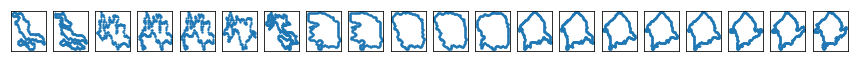

In [25]:
path = '/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/line107340.txt'
if os.name == "nt":
    path = 'E:/line107340.txt'
plotContourFromOriginalFile(path,limit_amount=20, add_milk=False)

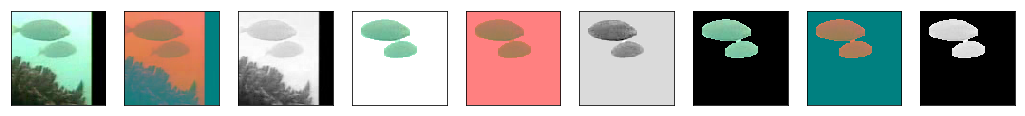

In [26]:
picker = 177
image1 = clip[picker]
thiscontour = getContour(contour[picker])
mask = np.full(image1.shape, 0, dtype=np.uint8)
cv2.fillPoly(mask, np.array([thiscontour], dtype=np.int32), (255,)*3)
image2 = cv2.cvtColor(image1,cv2.COLOR_RGB2YUV)
image3 = normalizeRGB(image2)[:,:,0]
image4 = cv2.bitwise_or(cv2.bitwise_not(mask),image1)
image5 = cv2.cvtColor(image4,cv2.COLOR_RGB2YUV)
image6 = normalizeRGB(image5)[:,:,0]
image7 = cv2.bitwise_and(mask,image1)
image8 = cv2.cvtColor(image7,cv2.COLOR_RGB2YUV)
image9 = normalizeRGB(image8)[:,:,0]
plt.subplots(1,9,figsize=(18,2))
for index, image in enumerate([image1,image2,image3,image4,image5,image6,image7,image8,image9]):
    plt.subplot(1,9,index+1)
    if (index+1)%3==0:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

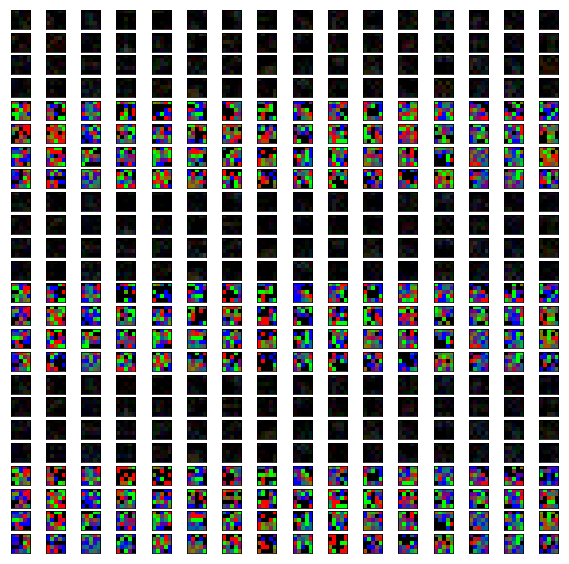

In [27]:
basepath = '/afs/inf.ed.ac.uk/user/s14/s1413557/f4k-2017-msc-master/matt-msc/src/lua/cnn/models/'
if os.name=="nt":
    basepath =  'C:/Users/YuJianmeng/f4k/matt-msc/src/lua/cnn/models/'
path_plasu = 'filters/B_C/1/'
path_plasu2 = 'filters/N/1/'
path_plasu3 = 'filters/W_C/1/'
#img = cv2.imread(basepath+path_plasu+'1.png')
plt.subplots(24,16,figsize=(10,10))
for i in range(64):
    plt.subplot(24,16,i+1)
    img = cv2.imread(basepath+path_plasu+str(i+1)+'.png')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
for i in range(64):
    plt.subplot(24,16,i+65)
    img = cv2.imread(basepath+path_plasu+str(i+1)+'.png')
    plt.imshow(normalizeRGB(img))
    plt.xticks([])
    plt.yticks([])
for i in range(64):
    plt.subplot(24,16,i+129)
    img = cv2.imread(basepath+path_plasu2+str(i+1)+'.png')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
for i in range(64):
    plt.subplot(24,16,i+193)
    img = cv2.imread(basepath+path_plasu2+str(i+1)+'.png')
    plt.imshow(normalizeRGB(img))
    plt.xticks([])
    plt.yticks([])
for i in range(64):
    plt.subplot(24,16,i+257)
    img = cv2.imread(basepath+path_plasu3+str(i+1)+'.png')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
for i in range(64):
    plt.subplot(24,16,i+321)
    img = cv2.imread(basepath+path_plasu3+str(i+1)+'.png')
    plt.imshow(normalizeRGB(img))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Windows Test Code below, cuz no library loves or support windows.

In [28]:
if os.name == "nt":    
    import matlab.engine
    eng = matlab.engine.start_matlab()
    eng.addpath(r'C:/Users/YuJianmeng/f4k/matt-msc/workspace/f4k/fish_recog',nargout=0)

In [29]:
if os.name == "nt":
    
    i = 0
    thiscontour = getContour(contour[i])
    mask = np.full(image.shape, 0, dtype=np.uint8)
    cv2.fillPoly(mask, np.array([thiscontour], dtype=np.int32), (255,)*3)
    full_fish = np.array((getMask(getContour(contour[i])).astype(int)*255),dtype="uint8")
    image = clip[i]

    eng.workspace['A'] = image.tolist()
    print(len(image.tolist()))

    (c,d) = eng.generateFeatureFromPython(image.reshape(1,-1).tolist(),full_fish.reshape(1,-1).tolist(),nargout=2)

    print(np.array(c,dtype="double").shape)

100
(1L, 2626L)


In [30]:
if os.name == "nt":
    eng.exit()
    eng.quit()
    del eng

# Below code only work on linux, somehow. (#JustPyMatlabThings)

In [31]:
if os.name != "nt":
    import pymatlab
    #session = pymatlab.session_factory()
    #session.run('cd C:/Users/YuJianmeng/f4k/matt-msc/workspace/f4k/fish_recog')

In [32]:
if os.name != "nt":
    time = datetime.now()
    for i in range(4716):
        thiscontour = getContour(contour[i])
        mask = np.full(image.shape, 0, dtype=np.uint8)
        cv2.fillPoly(mask, np.array([thiscontour], dtype=np.int32), (255,)*3)
        full_fish = np.array((getMask(getContour(contour[i])).astype(int)*255),dtype="uint8")
        image = clip[i]
        session.putvalue('A',image)
        session.putvalue('B',full_fish)
        session.run('[C, D] = feature_generateFeatureVector(A,B,false)')
        c = session.getvalue('C')
        d = session.getvalue('D')
        print("Process {0} image took {1}".format(i,datetime.now() - time), end='\r')
    print("Took a total of {0}           ".format(datetime.now() - time) )

In [33]:
if os.name != "nt":
    del session

# I thought code below would be useful but it's not

In [34]:
# `camera_id` int(11) NOT NULL AUTO_INCREMENT,
# `video_number` int(11) NOT NULL,
# `location` varchar(100) NOT NULL DEFAULT '',
# `camera_lens` varchar(60) DEFAULT NULL,
# `camera_angle` smallint(6) DEFAULT NULL,
# `depth` tinyint(3) DEFAULT NULL,

path_camera = '/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/cameras'
if os.name == "nt":
    path_camera = 'E:/cameras'
with open(path_camera,'r') as fp:
    for i, line in enumerate(fp):
        line = line[1:-2].split("),(")
        for l in line:
            print(l)
            l = l.split(",")
            #print()

37,1,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
38,3,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
39,4,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
40,1,'HoBiHu','3.6mm F1.8 1/3 inches CCD',0,5
41,2,'HoBiHu','3.6mm F1.8 1/3 inches CCD',0,5
42,2,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
43,3,'HoBiHu','3.6mm F1.8 1/3 inches CCD',0,5
44,1,'LanYu','3.6mm Iris:auto 1/3 inches CCD; white LED night sight',0,15
46,2,'LanYu','3.6mm Iris:auto 1/3 inches CCD; white LED night sight',0,15


In [44]:
time = datetime.now()
for i in range(10):
    __, clip2, __, __, __, __ = loadVideo(movs[i],print_info=False,print_image=False,print_time=True)
    print("Checked Video: {0}  ID: {1}, took: {2}".format(i, movs[i][0],datetime.now()-time), end='\r')

In [36]:
movs = loadMovids()

In [37]:
for i, item in enumerate(movs):
    if not(item[0][:2] == "00"):
        print(i)
        break
print(movs[i-1])
print(movs[i])

1584
['00f65fa25502674e59d8ae8bb44ff161#201009201420' '41' '0']
['01afaa3b9607e7b4f34a790e440e3d8e#201101121200' '46' '1']


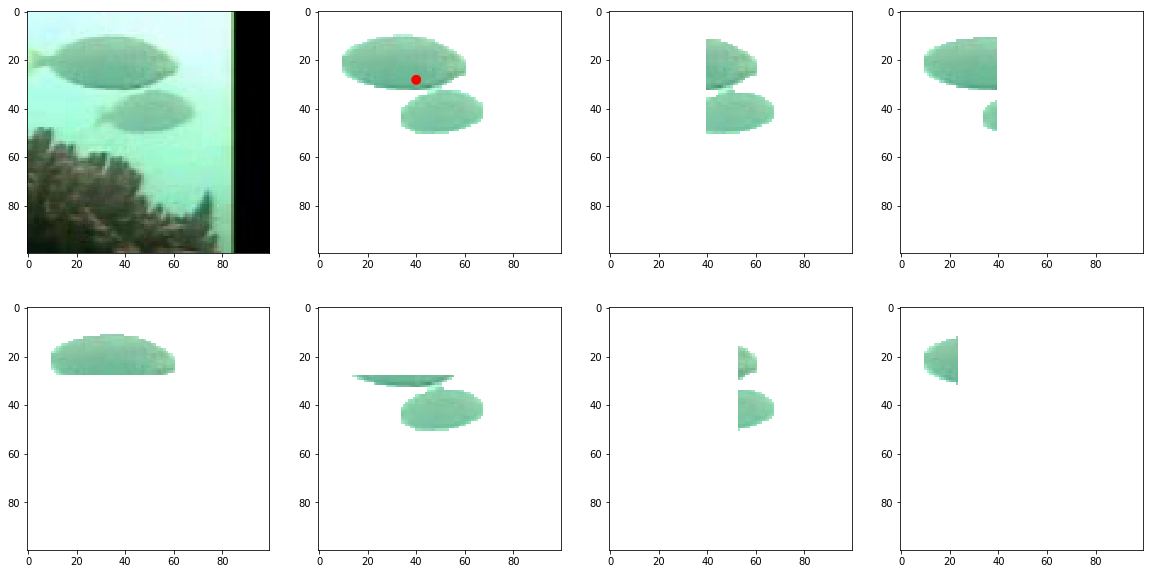

In [45]:
picker = 6
picker2 = 177
movid = movs[picker]
info, clip, hasContour, contour, fish_id, frames = loadVideo(movid,print_info=False, print_image=False)
cline = contour[picker2]
thisContour = getContour(cline)

full_fish, head_fish, tail_fish, top_fish, bot_fish, hhead_fish, htail_fish = seperate_fish(thisContour,info[picker2][1])
image = clip[picker2]

#Temp stuff
hf = np.array((head_fish.astype(int)*255)[:,:,None], dtype=np.uint8)
hf = np.dstack((hf,hf,hf))
tf = np.array((tail_fish.astype(int)*255)[:,:,None], dtype=np.uint8)
tf = np.dstack((tf,tf,tf))
tpf = np.array((top_fish.astype(int)*255)[:,:,None], dtype=np.uint8)
tpf = np.dstack((tpf,tpf,tpf))
btf = np.array((bot_fish.astype(int)*255)[:,:,None], dtype=np.uint8)
btf = np.dstack((btf,btf,btf))
hhf = np.array((hhead_fish.astype(int)*255)[:,:,None], dtype=np.uint8)
hhf = np.dstack((hhf,hhf,hhf))
htf = np.array((htail_fish.astype(int)*255)[:,:,None], dtype=np.uint8)
htf = np.dstack((htf,htf,htf))

#White mask with black shape
mask = np.full(image.shape, 255, dtype=np.uint8)
roi_corners = np.array([thisContour], dtype=np.int32)
ignore_mask_color = (0,)*3
cv2.fillPoly(mask, roi_corners, ignore_mask_color)

# apply the mask
masked_image = cv2.bitwise_or(image, mask)

#get values
moments = cv2.moments(cv2.bitwise_not(mask)[:,:,0])
xy = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))

plt.subplots(2,4,figsize=(20,10))
plt.subplot(241)
plt.imshow(image)
plt.subplot(242)
plt.imshow(masked_image)
plt.gca().add_patch(patches.Circle(xy,1,fill=True,linewidth=5,color='red'))
plt.subplot(243)
plt.imshow(cv2.bitwise_or(image, cv2.bitwise_not(hf)))
plt.subplot(244)
plt.imshow(cv2.bitwise_or(image, cv2.bitwise_not(tf)))
plt.subplot(245)
plt.imshow(cv2.bitwise_or(image, cv2.bitwise_not(tpf)))
plt.subplot(246)
plt.imshow(cv2.bitwise_or(image, cv2.bitwise_not(btf)))
plt.subplot(247)
plt.imshow(cv2.bitwise_or(image, cv2.bitwise_not(hhf)))
plt.subplot(248)
plt.imshow(cv2.bitwise_or(image, cv2.bitwise_not(htf)))
plt.show()

In [39]:
def histc(list1, bins):
    hist,__ = np.histogram(list1, bins)
    lastbin = np.sum(list1 == 1)
    hist[-1] = hist[-1] - lastbin
    hist = np.append(hist, lastbin)
    return hist

In [40]:
def generateFeatureVector(info, contour, hasContour, clip, picker):
    cline = contour[picker]
    thisContour = getContour(cline)
    full, head, tail, top, bottom, hhead, htail = seperate_fish(thisContour,info[picker][1])
    image = clip[picker]
    norm_image = normalizeRGB(image)
    h_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)[:,:,0]/180.0
    
    bins = np.arange(0,1.02,0.02)
    histrange_nr = [0, 0.01742,0.125,0.1884,0.226,0.26,0.2934,0.328,0.372,0.4512, 1]
    histrange_ng = [0, 0.298,0.3276,0.35,0.3734,0.404,0.4334,0.466,0.505,0.59, 1]
    histrange_h = [0, 0.2246,0.291,0.463,0.5648,0.6034,0.6248,0.6422,0.675,0.7164, 1]
    
    # ===== Normalized Red =====
    
    tempimage = norm_image[:,:,0][head]
    f_0001_0051 = histc(tempimage, bins)
    tempimage = norm_image[:,:,0][tail]
    f_0052_0102 = histc(tempimage, bins)
    tempimage = norm_image[:,:,0][top]
    f_0103_0153 = histc(tempimage, bins)
    tempimage = norm_image[:,:,0][bottom]
    f_0154_0204 = histc(tempimage, bins)
    tempimage = norm_image[:,:,0][full]
    f_0205_0255 = histc(tempimage, bins)
    
    # ===== Normalized Green =====
    
    tempimage = norm_image[:,:,1][head]
    f_0256_0306 = histc(tempimage, bins)
    tempimage = norm_image[:,:,1][tail]
    f_0307_0357 = histc(tempimage, bins)
    tempimage = norm_image[:,:,1][top]
    f_0358_0408 = histc(tempimage, bins)
    tempimage = norm_image[:,:,1][bottom]
    f_0409_0459 = histc(tempimage, bins)
    tempimage = norm_image[:,:,1][full]
    f_0460_0510 = histc(tempimage, bins)
    
    # ===== Normalized Hue =====
    
    tempimage = h_image[head]
    f_0511_0561 = histc(tempimage, bins)
    tempimage = h_image[tail]
    f_0562_0612 = histc(tempimage, bins)
    tempimage = h_image[top]
    f_0613_0663 = histc(tempimage, bins)
    tempimage = h_image[bottom]
    f_0664_0714 = histc(tempimage, bins)
    tempimage = h_image[full]
    f_0715_0765 = histc(tempimage, bins)
    
    # ===== Normalized Red =====
    
    tempimage = norm_image[:,:,0][head]
    f_0766_0776 = histc(tempimage, histrange_nr)
    tempimage = norm_image[:,:,0][tail]
    f_0777_0787 = histc(tempimage, histrange_nr)
    tempimage = norm_image[:,:,0][top]
    f_0788_0798 = histc(tempimage, histrange_nr)
    tempimage = norm_image[:,:,0][bottom]
    f_0799_0809 = histc(tempimage, histrange_nr)
    tempimage = norm_image[:,:,0][full]
    f_0810_0820 = histc(tempimage, histrange_nr)
    
    # ===== Normalized Green =====
    
    tempimage = norm_image[:,:,1][head]
    f_0821_0831 = histc(tempimage, histrange_ng)
    tempimage = norm_image[:,:,1][tail]
    f_0832_0842 = histc(tempimage, histrange_ng)
    tempimage = norm_image[:,:,1][top]
    f_0843_0853 = histc(tempimage, histrange_ng)
    tempimage = norm_image[:,:,1][bottom]
    f_0854_0864 = histc(tempimage, histrange_ng)
    tempimage = norm_image[:,:,1][full]
    f_0865_0875 = histc(tempimage, histrange_ng)
    
    # ===== Normalized Hue =====
    
    tempimage = h_image[head]
    f_0876_0886 = histc(tempimage, histrange_h)
    tempimage = h_image[tail]
    f_0887_0897 = histc(tempimage, histrange_h)
    tempimage = h_image[top]
    f_0898_0908 = histc(tempimage, histrange_h)
    tempimage = h_image[bottom]
    f_0909_0919 = histc(tempimage, histrange_h)
    tempimage = h_image[full]
    f_0920_0930 = histc(tempimage, histrange_h)
    

---